In [1]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar100
from tensorflow.keras.layers import (Conv2D,Dense,MaxPooling2D,Activation,
                                     Flatten,Input,Dropout,BatchNormalization)
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
(train_imgs,train_labels),(test_imgs,test_labels) = cifar100.load_data()
train_imgs = train_imgs.astype('float32')/255.0
test_imgs = test_imgs.astype('float32')/255.0

169001437/169001437 [==============================] - 6s 0us/step


In [3]:
cifar100_fine_labels = [
    'apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle',
    'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel',
    'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock',
    'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur',
    'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster',
    'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion',
    'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse',
    'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear',
    'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum',
    'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea', 'seal', 'shark',
    'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel',
    'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone',
    'television', 'tiger', 'tractor', 'train', 'trout', 'tulip', 'turtle', 'wardrobe',
    'whale', 'willow_tree', 'wolf', 'woman', 'worm'
]


In [4]:
batch_size = 64
test_dataset = tf.data.Dataset.from_tensor_slices((test_imgs,test_labels))
test_dataset = test_dataset.shuffle(len(test_imgs)).batch(batch_size)
test_dataset = test_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [5]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_imgs,train_labels))
train_dataset = train_dataset.shuffle(len(train_imgs)).batch(batch_size)
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [6]:
def plot_imgs(imgs,labels,pred_labels=None):
  figs,axs = plt.subplots(8,4,figsize=(40,40))
  x = 0
  for i in range(8):
    for j in range(4):
      axs[i,j].imshow(imgs[x])

      if(type(pred_labels) == np.ndarray):
        axs[i,j].set_title("T :"+cifar100_fine_labels[(labels[x][0])]+"  P:"+cifar100_fine_labels[(pred_labels[x][0])],fontsize=20)

      else:
        axs[i,j].set_title(cifar100_fine_labels[(labels[x][0])],fontsize=24)
      x+=1


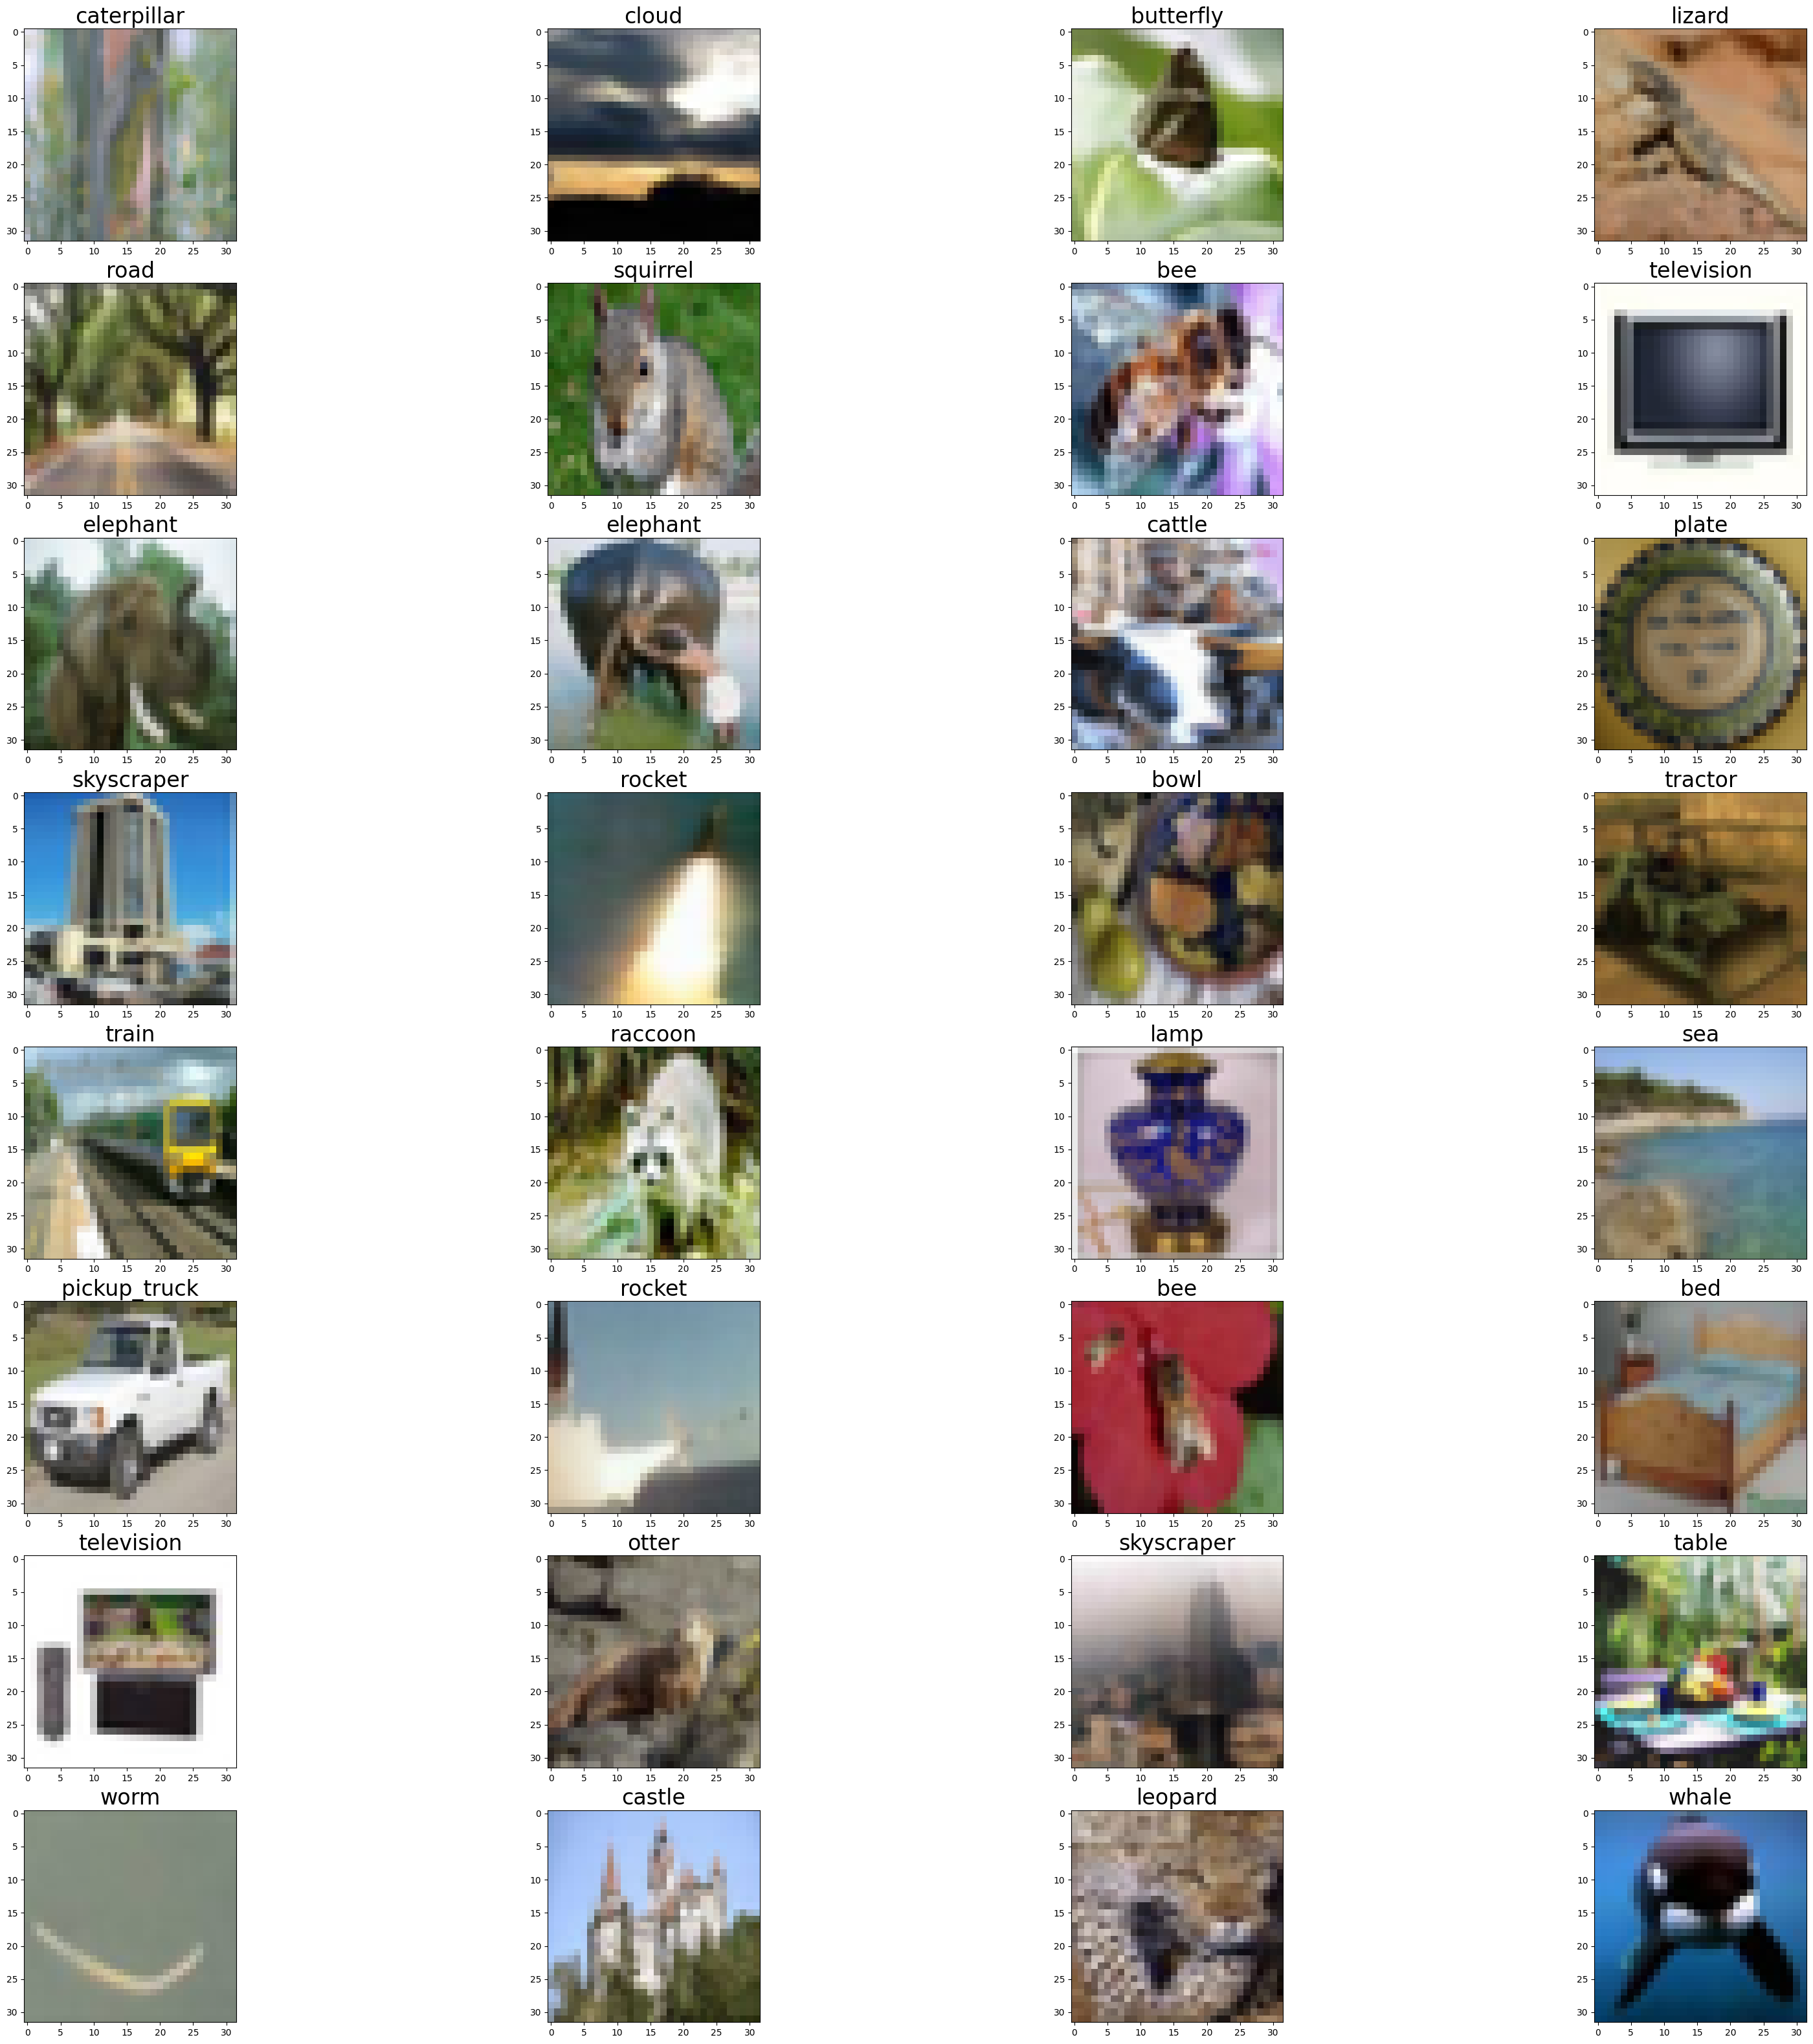

In [7]:
iterator = iter(train_dataset)
batch = next(iterator)
imgs,labels = batch
imgs - imgs.numpy()
labels = labels.numpy()
plot_imgs(imgs,labels)


In [8]:
def conv_block(filters,kernel):
  model = tf.keras.Sequential([
      Conv2D(filters,kernel_size=kernel,padding='same'),
      Activation('relu'),
      Conv2D(filters,kernel_size=kernel,padding='same'),
      Activation('relu'),
      BatchNormalization(),
      MaxPooling2D()
  ])

  return model

In [9]:
tf.random.set_seed(47)
def create_model():
  filters = [34,64,128]
  model = tf.keras.Sequential([
      Input((32,32,3)),
      conv_block(filters[0],kernel=3),      #(16,16)

      conv_block(filters[1],kernel=3),      #(8,8)
      Dropout(0.1),

      conv_block(filters[2],kernel=3),       #(4,4)
      Dropout(0.25),

      Flatten(),
      Dense(256,activation='relu'),
      BatchNormalization(),
      Dropout(0.5),
      Dense(100,activation='softmax')
  ])

  return model

model = create_model()
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

In [10]:
history = model.fit(train_dataset,
          batch_size=64,
          epochs=40,
          validation_data=test_dataset,
          validation_batch_size=64)


Epoch 1/40
782/782 [==============================] - 27s 15ms/step - loss: 4.0306 - accuracy: 0.1135 - val_loss: 3.4522 - val_accuracy: 0.1862
Epoch 2/40
782/782 [==============================] - 11s 14ms/step - loss: 3.1163 - accuracy: 0.2362 - val_loss: 2.7599 - val_accuracy: 0.3093
Epoch 3/40
782/782 [==============================] - 11s 13ms/step - loss: 2.6764 - accuracy: 0.3199 - val_loss: 2.5590 - val_accuracy: 0.3434
Epoch 4/40
782/782 [==============================] - 11s 13ms/step - loss: 2.4084 - accuracy: 0.3743 - val_loss: 2.4615 - val_accuracy: 0.3705
Epoch 5/40
782/782 [==============================] - 11s 14ms/step - loss: 2.1986 - accuracy: 0.4164 - val_loss: 2.0639 - val_accuracy: 0.4526
Epoch 6/40
782/782 [==============================] - 11s 14ms/step - loss: 2.0380 - accuracy: 0.4525 - val_loss: 2.1808 - val_accuracy: 0.4285
Epoch 7/40
782/782 [==============================] - 10s 13ms/step - loss: 1.9226 - accuracy: 0.4797 - val_loss: 2.3510 - val_accuracy:

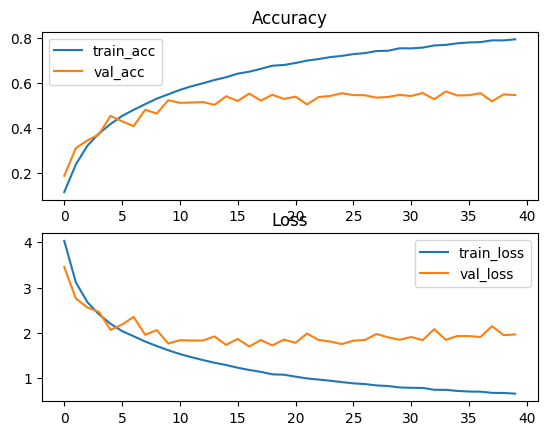

In [13]:
train_loss = history.history['loss']
train_accuracy = history.history['accuracy']

val_loss = history.history['val_loss']
val_accuracy = history.history['val_accuracy']

fig,axs = plt.subplots(2,1)
axs[0].plot(train_accuracy)
axs[0].plot(val_accuracy)
axs[0].set_title("Accuracy")
axs[0].legend(['train_acc','val_acc'])
axs[1].plot(train_loss)
axs[1].plot(val_loss)
axs[1].set_title('Loss')
axs[1].legend(['train_loss','val_loss'])

2/2 [==============================] - 0s 6ms/step


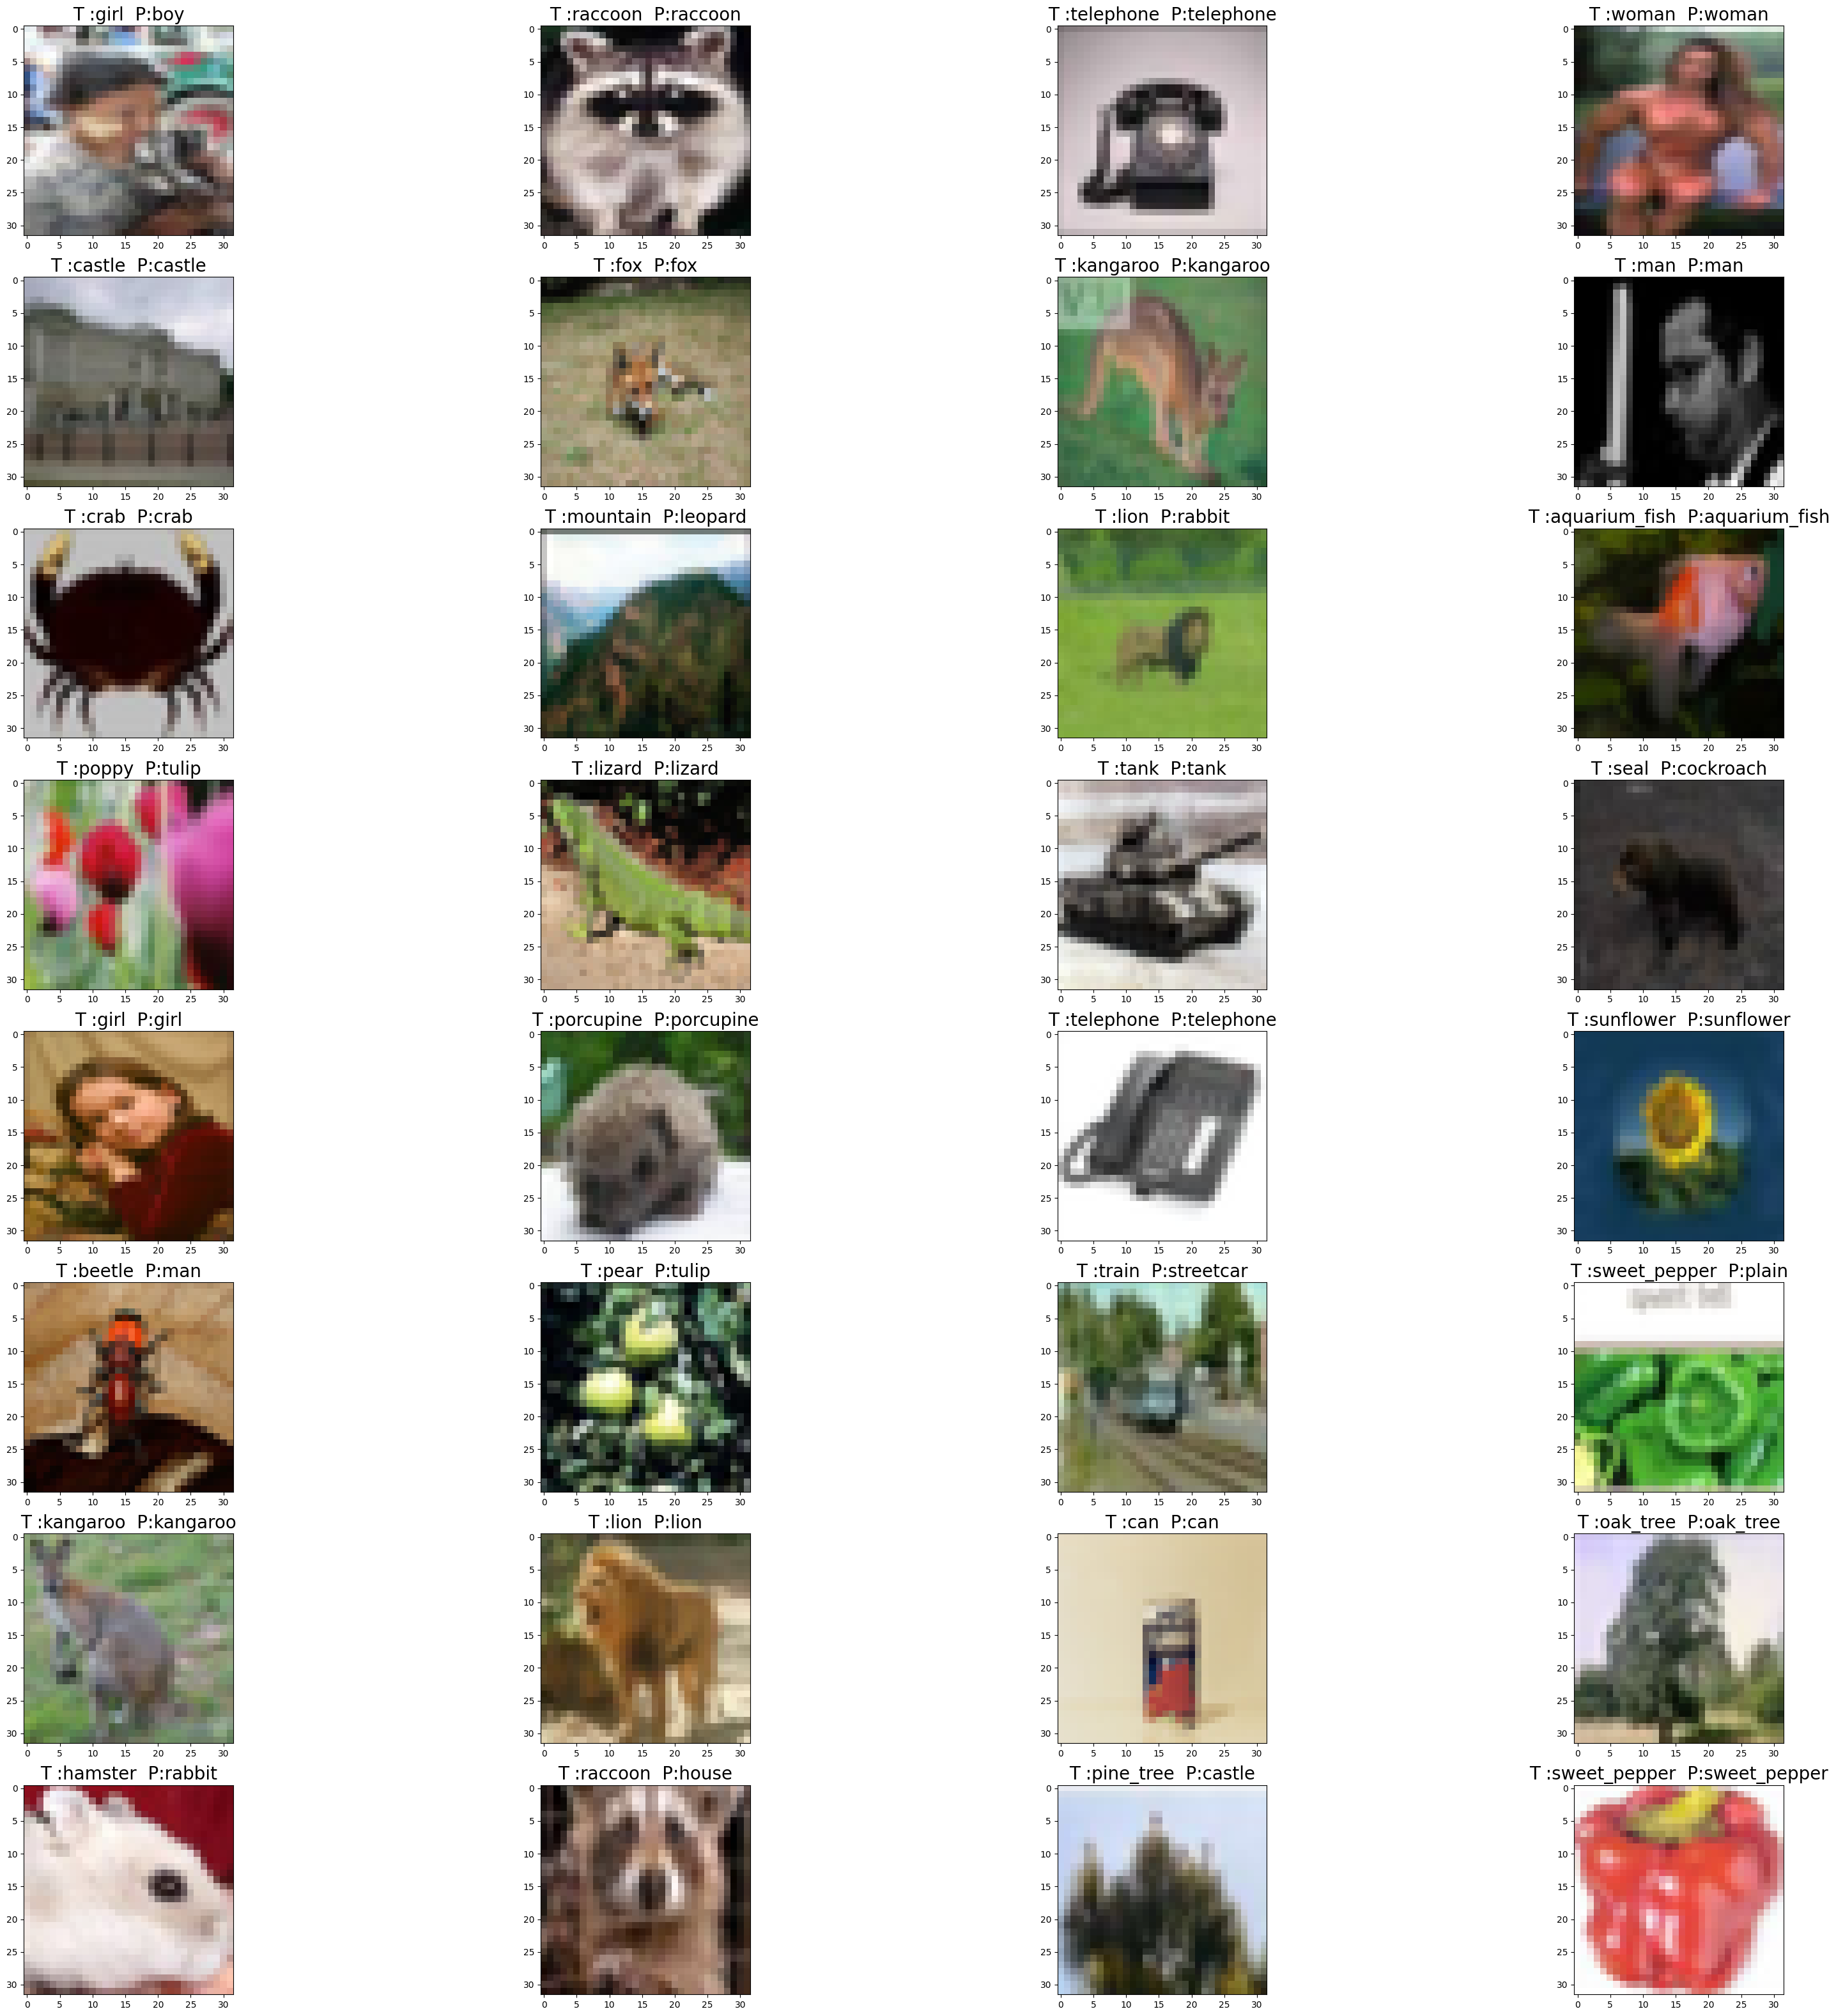

In [14]:
test_iteration = iter(test_dataset)
test_imgs,test_labels = next(test_iteration)
pred_labels = model.predict(test_imgs)
pred_labels = np.argmax(pred_labels,axis=1)
pred_labels = pred_labels.reshape((64,1))
plot_imgs(test_imgs,labels=test_labels,pred_labels=pred_labels)